# Project Stage-2: 2nd EDA, Data Transformation, Modeling, and Inference
**Nicole Guobadia**

**December 2nd, 2021**

Now for the project, you have a problem to solve and a dataset to use. In this 2nd stage, you are going to show how you transform the data based on EDA or use EDA to figure out certain features that you will use for modeling. Then, you will apply your own chosen model(s) to conduct modeling for prediction. Moreover, you are ready to do inference and compare between different models to improve your leaderboard position as much as possible.

## Requirements
### 1.1 Stage-1

### 1.2 EDA and Data Transformation
This is an open question. The goal of this section is to prepare the data ready for modeling. First, the raw data you have may not be ready for even very simple EDA.

* Describe the transformations of the data you have applied if applicable. Why or Why not? [10 points]
Second, you probably have a certain number of features that you can use. You may choose to use all or some.
* What are the features you choose to use for modeling? Why? Note: You may use EDA to show the reason. [5 points]
Finally, you will have the data ready for prediction. 
* Readiness of the data. [2 points] [HINT: for some models, the value range of your features can affect the model a lot. Data normalization may be needed, o.w., one feature with huge values may dominate the modeling effect]

### 1.3 Modeling
To solve your prediction problem, you need to choose a specific model and choose a specific loss function to estimate the model's parameters. The method can be novel proposal from yourself or existing methods. 

* Describe the chosen model and why choose this one. [3 points]
* Describe how the chosen features in 1.2 are involved in the chosen model (e.g., weighted linear combination of features in a linear model). [2 points]
* Describe the loss function that will be used to estimate the model's parameters (HINT: MSE? MAE? or others? if you are using an existing lib, you may need to check its document or google to figure out ). [2 points]
* Use a specific way (different ways have been discussed in A3) to estimate the model's parameters (e.g., sklearn's fit). [2 points]
* Use the model estimated to conduct a submission to the Kaggle competition and screenshot your leaderboard position. [3 points] 

### 1.4 Inference
In 1.3, you may have used the whole training data to do the model estimation. In this way, you have to submit many times to the leaderboard to compare the performance of different potential models (e.g., models using different subset of features, different models [i.e., SVM vs. Logistic Regression] using the same subset of features). This is actually not desired in real applications of data science. Therefore, you are required to choose another model to have at least two models (in your favor, any applicable ones, you can do literature review to see potential ones): A (model chosen in 1.3) and B, and compare their performance using cross validation (e.g., If you had to choose between A and B, which is better and why?). Your experiment should include but not limited to the following items.

* Correct choose of standard evaluation metric(s) for comparison, e.g., MSE for regression, accuracy for classification. [2 points] 
* Sound data splitting for train and test using only the training data to fairly compare A and B (main idea can be borrowed from A3). [5 points]
* Fair performance comparison between A and B with clear explanation on which is better and why (without loss of significance test, main idea can be borrowed from A3). [5 points]
* Conduct at least another submission to Kaggle and check if your leaderboard position can be improved (embed new screenshot for your leaderboard position in your notebook). [2 point]
* Bonus [+4 points]: the team with the top leaderboard position of each project in this class will obtain bonus points and a prize from Juhua conditioned on a presentation sharing in the last lecture.

Potentially useful tips for all of you, although performance improvement is not guaranteed
* Do not blindly drop a column with high missing rate or fill with mean, median, random, etc. Understand the meaning of missing at first. For example, if not available, the value can be 0. If you have different groups (e.g., child, adult), you may fill using the within group information.
* Data normalization should change the value to meaningful range, e.g., age can be normalized but not to negative values. 
* For regression, outliers far away from your model assumption can be penalized a lot. The optimization procedure for the model estimation will be mislead by these outliers.
* For classification, stratified sampling is important to cover all classes for splitting. For the training data, it is important to check if classes are balanced. If not, the major class may dominate your model estimation. You may want to balance your training data.

### 1.5 Conclusions and Learnings
In this section, you can summarize your project and conclude your findings based on what you have done for the whole project. Additionally, please state what you have learned from this project in this course.

* A convincing conclusion about the findings. [2 points]
* What you have learned from this project. [2 points]

# Imports and Setup
**Note:** for a large portion of this notebook I will be using an application called [Weights and Biases (wandb)](https://docs.wandb.ai/). This is where a majority of my hyperparameter tuning and data visualizations will exist, however I will be placing important information from relevant runs within the notebook. To see all of the sweeps done, click [here](https://wandb.ai/nclgbd/Titanic-Classification/sweeps?workspace=user-nclgbd)

In [19]:
import os
import csv
import re
import random
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
from pprint import pprint
from dotenv import dotenv_values
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

from statistics import (fmean, 
                        stdev)

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

# for encoding categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder)

%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [20]:
# Directories and wandb setup
DATA_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"
PROJECT_ENV = dotenv_values("config/project.env")
PROJECT = PROJECT_ENV["project"]
ENTITY = PROJECT_ENV["entity"]
os.environ['WANDB_NOTEBOOK_NAME'] = os.path.join(os.getcwd(), "ProjectStage2.ipynb")

wandb.login();

## Reload the data using methods from the previous notebook

In [21]:
# load the data - it is available open source and online
data = pd.read_csv(DATA_DIR)
test_data = pd.read_csv(TEST_DIR)
new_columns_dict = dict(zip(data.columns, [col.lower() for col in data.columns]))
data = data.rename(columns=new_columns_dict)
test_data = test_data.rename(columns=new_columns_dict)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
data = data.replace('?', np.nan)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
data.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Feature Engineering
Recall from the last notebook, there we used a method to see the correlation between two different features, specifically to see how predictive certain features were for predicting survival. To take advantage of this, we'll create some new features for predicting instead:

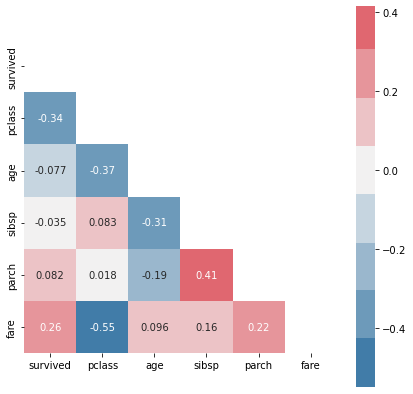

In [26]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
data_no_pid = data.drop(columns="passengerid")
data_corr = data_no_pid.corr()
mask = np.triu(np.ones_like(data_corr, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9)

plt.figure(figsize=(7,7))
sns.heatmap(data_corr, mask=mask, center=0,
            square=True, cmap=palette, annot=True)
plt.show()

## Creating new features
We'll start by modifying the `cabin` feature, as we only really care about the letter rather than the number that follows. By doing this, we also make this feature more useful for classification as we've created another feature to predict on

In [27]:
# retain only the first cabin if more than
# 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)
data['cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in data['cabin']])
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S


In [28]:
data["cabin"].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

We'll also go ahead and impute the median here. There is a later step that does this, however we'll need all of the values to be able to create our next feature:

In [29]:
data["age"] = data["age"].replace(np.nan, data["age"].median())
data.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We'll now create a new feature called `agegroup`. This will transform the `age` column from a numerical data point to a categorical one, which may be more useful for training:

In [30]:
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
def create_age_group(age):
    if age > 66:
        return 6
    elif age > 40:
        return 5
    elif age > 33:
        return 4
    elif age > 27:
        return 3
    elif age > 22:
        return 2
    elif age > 18:
        return 1
    else:
        return 0

data['agegroup'] = data['age'].apply(create_age_group)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4


Now, we'll create another a `single` feature, which represents whether or not a particular passenger was the only person on board, or if they had other family members. The idea behind this feature is that if a passenger has family members on board, they may be more likely to be able to board a boat. We do this by adding up the number of siblings and parents of each passenger and creating a binary boolean representing whether the passenger was traveling alone or not

In [31]:
data["relatives"] = data['sibsp'] + data["parch"]
def create_is_single():
    if data["relatives"] > 0:
        return 0
    else:
        return 1
    
data['single'] = data["relatives"].apply(create_age_group)
data = data.drop(["relatives"], axis=1)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup,single
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4,0


Another feature we'll create is a `title` feature, as they may indicate socioeconomic class standing and thus may influence a passenger's likelihood of surviving

In [32]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,agegroup,single,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,2,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,4,0,Mr


We'll now create a transformer for extracting the first letter from the cabin like we did earlier. This is done so that the step can be integrated into the pipeline itself, which will be explained in more detail in the next section

In [33]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    # Extract fist letter of variable
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        # so that we do not over-write the original dataframe
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = X[feature].str[0]

        return X

Now lets take one last look at our data and get ready for training!

In [34]:
# list of variables to be used in the pipeline's transformers
NUMERICAL_VARIABLES = ['age', 'fare']
CATEGORICAL_VARIABLES = ['sex', 'cabin', "title"]
CABIN = ["cabin"]

# drop unnecessary variables
data = data.drop(labels=['name', 'ticket', "embarked", "passengerid"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   cabin     891 non-null    object 
 8   agegroup  891 non-null    int64  
 9   single    891 non-null    int64  
 10  title     891 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


We'll go ahead and look at the correlation heatmap again:

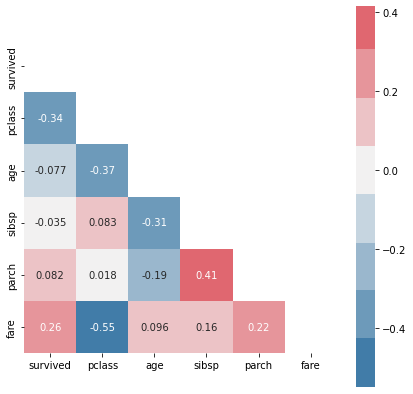

In [35]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# data_no_pid = data.drop(columns="passengerid")
data_corr = data_no_pid.corr()
mask = np.triu(np.ones_like(data_corr, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9)

plt.figure(figsize=(7,7))
sns.heatmap(data_corr, mask=mask, center=0,
            square=True, cmap=palette, annot=True)
plt.show()

# Training Approach 1: Naive
We'll first try a naive approach to training. The `_train` function below contains the actual training process, while a later function will be defined that will add more evaluation and logs. To walk through what exactly this code is doing, we'll be using the [`Pipeline` class](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in sklearn. Each step is defined as follows:

* `CategoricalImputer` - finds any categorical data points that are missing
* `AddMissingIndicator` - finds any numerical data points that are missing
* `MeanMedianImputer` - finds any missing numerical data and imputes the median
* `ExtractLetterTransformer` - grabs the first letter of the cabin, as there may be multiple cabins per traveller
* `RareLabelEncoder` - finds categories that appear less than 5% of the time in the dataset. 
* `OneHotEncoder` - changes the categorical data points into [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* `StandardScaler` - normalizes numerical data points
* Finally, with all the data properly prepped, the model can make it's predictions

From here, we'll calculate some evaluation metrics that will be useful for interpretting how well the model is actually performing. We'll be looking at **accuracy, precision, recall, [f1 score](https://en.wikipedia.org/wiki/F-score), and [auc (area under the curve)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)**

In [36]:
def _train(model_name, X, y, train_idx, valid_idx, config=None, verbose=0):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    model = make_model(model_name, config, verbose=verbose)

    # split the data
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # set up the pipeline
    titanic_pipe = Pipeline([
        # ===== IMPUTATION =====
        # impute categorical variables with string missing
        ('categorical_imputation', CategoricalImputer(
            imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

        # add missing indicator to numerical variables
        ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

        # impute numerical variables with the median
        ('median_imputation', MeanMedianImputer(
            imputation_method='median', variables=NUMERICAL_VARIABLES)),
    
        # Extract letter from cabin
        ('extract_letter', ExtractLetterTransformer(variables=CABIN)),

        # == CATEGORICAL ENCODING ======
        # remove categories present in less than 5% of the observations (0.05)
        # group them in one category called 'Rare'
        ('rare_label_encoder', RareLabelEncoder(
            tol=0.05, n_categories=1, variables=CATEGORICAL_VARIABLES)),

        # encode categorical variables using one hot encoding into k-1 variables
        ('categorical_encoder', OneHotEncoder(
            drop_last=True, variables=CATEGORICAL_VARIABLES)),

        # scale
        ('scaler', StandardScaler()),

        # predict
        (model_name, model),
    ])
    
    titanic_pipe.fit(X_train, y_train)
    y_probas = titanic_pipe.predict_proba(X_valid)
    y_pred = titanic_pipe.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred)
    
    return (titanic_pipe, 
            y_valid, y_probas, y_pred, 
            accuracy, precision, recall, f1, auc)
        

Below is the specific function we'll call for training. We'll be using Stratified KFold Cross Validation to evaluate the model. 

In [37]:
def train(model_name, X, y, dry_run=True, config=None, verbose=0):
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores = []
    best_model: Pipeline
    highest_acc = -1
    
    # USING SKLEARN, NO HYPERPARAMETER SEARCH
    if dry_run:
        model_filepath = os.path.join(os.getcwd(), "models")
        for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
            (titanic_pipe, 
            y_valid, y_probas, y_pred, 
            accuracy, precision, recall, f1, auc) = _train(model_name, X, y, train_idx, valid_idx, config, verbose)
            
            print(classification_report(y_valid, y_pred))
            cm = confusion_matrix(y_valid, y_pred)
            cm_plot = ConfusionMatrixDisplay(cm, display_labels=titanic_pipe.classes_)
            cm_plot.plot()
            plt.show(cm_plot)
            
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            auc_scores.append(auc)
            
            if highest_acc < 0: # first run, just set it
                best_model = titanic_pipe
            else:
                best_model = best_model if highest_acc > accuracy else titanic_pipe
            
            highest_acc = max(highest_acc, accuracy)
        
        print(f"Average Mean: {fmean(accuracies):.5f} +/- {stdev(accuracies):.4f}")
        print(f"Average Precision: {fmean(precisions):.5f} +/- {stdev(precisions):.4f}")
        print(f"Average Recall: {fmean(recalls):.5f} +/- {stdev(recalls):.4f}")
        print(f"Average F1 Score: {fmean(f1_scores):.5f} +/- {stdev(f1_scores):.4f}")
        print(f"Average AUC Score: {fmean(auc_scores):.5f} +/- {stdev(auc_scores):.4f}")
        
        # Save the best model on wandb
        full_path = os.path.join(model_filepath, "".join([model_name.lower(),'.joblib']))
        dump(best_model, full_path)
                
        
    # USING WEIGHTS AND BIASES      
    else:
        run = wandb.init(project=PROJECT, 
                        entity=ENTITY, 
                        config=config,
                        reinit=True)
        
        with run:
            model_filepath = os.path.join(os.getcwd(), "models")
            avg_metrics_dict = {}
            column_names = ["accuracy", "precision", "recall", "f1", "auc"]
            
            for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
                config = run.config
                model_id = "".join([str(idx+1), "_", str(run.id)])
                
                (titanic_pipe, 
                y_valid, y_probas, y_pred, 
                accuracy, precision, recall, f1, auc) = _train(model_name, X, y, train_idx, valid_idx, config, verbose)
                
                pr = wandb.plot.pr_curve(y_valid, y_probas)
                wandb.log({f"pr_curve": pr})
                
                cm = confusion_matrix(y_valid, y_pred)
                wandb.log({f"confusion matrix [{model_id}]": wandb.Table(columns=["died", "survived"],
                                                                         rows=["died", "survived"],
                                                                         data=cm)})
            
                accuracies.append(accuracy)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                auc_scores.append(auc)
                
                if highest_acc < 0: # first run, just set it
                    best_model = titanic_pipe
                else:
                    best_model = best_model if highest_acc > accuracy else titanic_pipe
                
                highest_acc = max(highest_acc, accuracy)
                
            # Log metrics using wandb  
            avg_metrics_dict["avg_acc"] = fmean(accuracies)  
            avg_metrics_dict["avg_acc_std"] = stdev(accuracies)
            
            avg_metrics_dict["avg_precision"] = fmean(precisions)
            avg_metrics_dict["avg_precision_std"] = stdev(precisions)
            
            avg_metrics_dict["avg_recall"] = fmean(recalls)
            avg_metrics_dict["avg_recall_std"] = stdev(recalls)
            
            avg_metrics_dict["avg_f1_score"] = fmean(f1_scores)
            avg_metrics_dict["avg_f1_score_std"] = stdev(f1_scores)
            
            avg_metrics_dict["avg_auc_score"] = fmean(auc_scores)
            avg_metrics_dict["avg_auc_score_std"] = stdev(auc_scores)
            
            wandb.log(avg_metrics_dict)
            
            # Create a table of all the individual metrics
            wandb.log({f"performance_metrics_{run.id}]": wandb.Table(columns=column_names,
                                                                     data=[accuracies,
                                                                           precisions, 
                                                                           recalls, 
                                                                           f1_scores,
                                                                           auc_scores])})
            
            # Save the best model on wandb
            full_path = os.path.join(model_filepath, "".join([model_name.lower(),'.joblib']))
            dump(best_model, full_path)
            run.log_artifact(full_path, 
                             name=f"{model_name.lower()}", 
                             aliases=str(run.id), 
                             type="model")
            
    return (accuracies, precisions, recalls, f1_scores, auc_scores)

For our naive approach, we will simply provide a dictionary representation of our hyperparameters for RF and DF classifiers.

In [38]:
rfc_config = {
    "n_estimators": 100,
    "min_samples_leaf": 10,
    "criterion": "gini"
}

dtc_config = {
    "min_samples_leaf": 10,
    "criterion": "gini",
    "splitter": "best"
}

In [39]:
def make_model(model_name, config, verbose=0):
    if model_name.lower() == "rfc":
        return RandomForestClassifier(n_estimators=config["n_estimators"],
                                      min_samples_leaf=config["min_samples_leaf"],
                                      criterion=config["criterion"],
                                      verbose=verbose,
                                      random_state=42)
        
    elif model_name.lower() == "dtc":
        return DecisionTreeClassifier(min_samples_leaf=config["min_samples_leaf"],
                                      criterion=config["criterion"],
                                      splitter=config["splitter"],
                                      random_state=42)

## Basic Training Run Output
Now we train! For ever fold we train on (5 in total), we will see the different performance metrics displayed using sklearn's [`classification_report` function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Then, we'll see all of the averages for each metric and calculate their standard deviation.

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



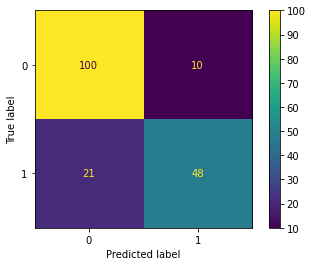

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.69      0.73        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178



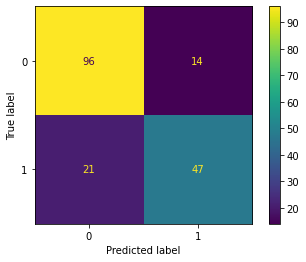

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.74      0.76        68

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.83      0.82       178



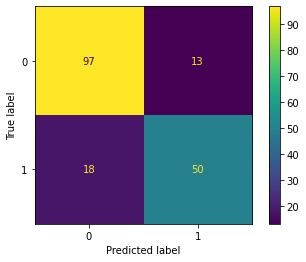

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.78      0.62      0.69        68

    accuracy                           0.79       178
   macro avg       0.78      0.75      0.76       178
weighted avg       0.79      0.79      0.78       178



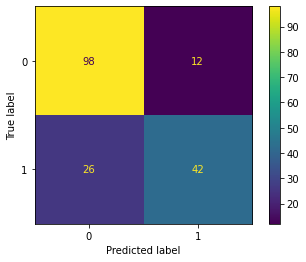

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       109
           1       0.80      0.77      0.79        69

    accuracy                           0.84       178
   macro avg       0.83      0.82      0.83       178
weighted avg       0.84      0.84      0.84       178



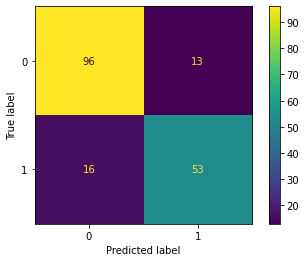

Average Mean: 0.81592 +/- 0.0205
Average Precision: 0.79451 +/- 0.0225
Average Recall: 0.70158 +/- 0.0565
Average F1 Score: 0.74433 +/- 0.0372
Average AUC Score: 0.79432 +/- 0.0271


([0.8268156424581006,
  0.8033707865168539,
  0.8258426966292135,
  0.7865168539325843,
  0.8370786516853933],
 [0.8275862068965517,
  0.7704918032786885,
  0.7936507936507936,
  0.7777777777777778,
  0.803030303030303],
 [0.6956521739130435,
  0.6911764705882353,
  0.7352941176470589,
  0.6176470588235294,
  0.7681159420289855],
 [0.7559055118110236,
  0.7286821705426356,
  0.7633587786259542,
  0.6885245901639345,
  0.785185185185185],
 [0.8023715415019763,
  0.781951871657754,
  0.8085561497326204,
  0.7542780748663102,
  0.8244249434915569])

In [40]:
train("RFC", data.drop('survived', axis=1), data['survived'], config=rfc_config)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       110
           1       0.75      0.77      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



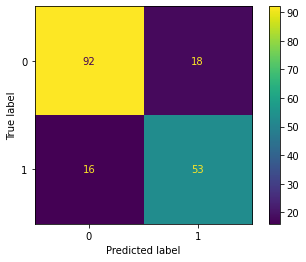

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.69      0.73        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178



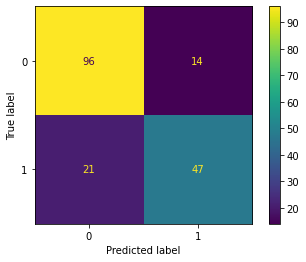

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       110
           1       0.91      0.75      0.82        68

    accuracy                           0.88       178
   macro avg       0.89      0.85      0.86       178
weighted avg       0.88      0.88      0.87       178



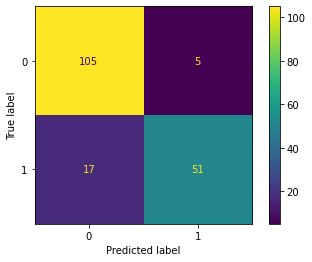

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       110
           1       0.90      0.63      0.74        68

    accuracy                           0.83       178
   macro avg       0.85      0.79      0.81       178
weighted avg       0.84      0.83      0.82       178



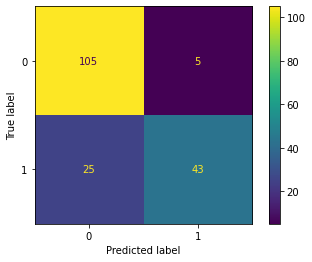

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       109
           1       0.80      0.65      0.72        69

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



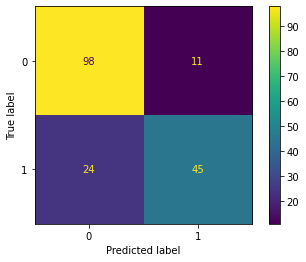

Average Mean: 0.82493 +/- 0.0310
Average Precision: 0.82542 +/- 0.0741
Average Recall: 0.69876 +/- 0.0593
Average F1 Score: 0.75396 +/- 0.0408
Average AUC Score: 0.80111 +/- 0.0304


([0.8100558659217877,
  0.8033707865168539,
  0.8764044943820225,
  0.8314606741573034,
  0.8033707865168539],
 [0.7464788732394366,
  0.7704918032786885,
  0.9107142857142857,
  0.8958333333333334,
  0.8035714285714286],
 [0.7681159420289855,
  0.6911764705882353,
  0.75,
  0.6323529411764706,
  0.6521739130434783],
 [0.7571428571428571,
  0.7286821705426356,
  0.8225806451612904,
  0.7413793103448276,
  0.7200000000000001],
 [0.8022397891963109,
  0.781951871657754,
  0.8522727272727273,
  0.7934491978609626,
  0.7756282409254087])

In [41]:
train("DTC", data.drop('survived', axis=1), data['survived'], config=dtc_config)

We can see the performance of these models is fairly lukewarm, and the main reason is likely because we haven't tuned the hyperparameters for the RF and DT classifiers. To fix this, we'll do some hyperparameters sweeps.

# Training Approach 2: Tune Hyperparameters with Sweeps using Weights and Biases
It's clear we can likely do better with both models, so I'm going to do a hyperparameter sweep/search using Weights and Biases. You can see the specific sweeps I performed [here](https://wandb.ai/nclgbd/Titanic-Classification/sweeps?workspace=user-nclgbd), but I will explain the general process. I first started out with a random search, as a grid search would be far too computationally complex, especially since I wasn't sure quite where to start using, however I was sure I wanted to use a Random Forest and Decision Tree Classifier, as I'm more familiar with the architecture of those models. The random search ran 10 times, and I would look at common trends in the metrics that were returned to further narrow the scope of the hyperparameter values.

### RFC Sweep Configuration Setup

In [72]:
# Initialize random forest sweep
rfc_ts = '{0:010x}'.format(int(time() * 256))[:5] # for getting a unique
rfc_sweep_config = {
    "name": f"rfc-{rfc_ts}",
    "method": "random"
}

metric = {
    "name": "avg_acc",
    "goal": "maximize"
}

parameters = {
    "n_estimators": {
        "distribution": "int_uniform",
        "min": 5000,
        "max":6000
        },
    
    "criterion" : {
        "values": ["gini", "entropy"]
        },
    
    "min_samples_leaf" : {
        "value": 1
        }
}

rfc_sweep_config["metric"] = metric
rfc_sweep_config["parameters"] = parameters
pprint(rfc_sweep_config)

rfc_sweep_id = wandb.sweep(rfc_sweep_config, 
                           project=PROJECT, 
                           entity=ENTITY)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'avg_acc'},
 'name': 'rfc-61a9a',
 'parameters': {'criterion': {'values': ['gini', 'entropy']},
                'min_samples_leaf': {'value': 1},
                'n_estimators': {'distribution': 'int_uniform',
                                 'max': 6000,
                                 'min': 5000}}}
Create sweep with ID: xd4t5sbu
Sweep URL: https://wandb.ai/nclgbd/Titanic-Classification/sweeps/xd4t5sbu


### DTC Sweep Configuration Setup

In [138]:
# Initialize decision tree sweep
rnd = int(random.uniform(2, 1024))
dtc_ts = '{0:010x}'.format(int(time() * rnd))[:5] # for getting a unique name
dtc_sweep_config = {
    "name": f"dtc-{dtc_ts}",
    "method": "random"
}

metric = {
    "name": "avg_acc",
    "goal": "maximize"
}

parameters = {
    "splitter": {
        "value": "best"
        },
    
    "criterion" : {
        "values": ["gini", "entropy"]
        },
    
    "min_samples_leaf" : {
        "value": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        }
}

dtc_sweep_config["metric"] = metric
dtc_sweep_config["parameters"] = parameters
pprint(dtc_sweep_config)

dtc_sweep_id = wandb.sweep(dtc_sweep_config, 
                           project=PROJECT, 
                           entity=ENTITY)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'avg_acc'},
 'name': 'dtc-e9797',
 'parameters': {'criterion': {'values': ['gini', 'entropy']},
                'min_samples_leaf': {'value': 50},
                'splitter': {'value': 'best'}}}
Create sweep with ID: i948icng
Sweep URL: https://wandb.ai/nclgbd/Titanic-Classification/sweeps/i948icng


In [27]:
def sweep_rfc(config=None):
    train("RFC", data.drop('survived', axis=1), data['survived'], dry_run=False, config=config)

In [70]:
def sweep_dtc(config=None):
    train("DTC", data.drop('survived', axis=1), data['survived'], dry_run=False, config=config)

## Random Forest Classifier (RFC) Analysis

In [29]:
wandb.agent(rfc_sweep_id, sweep_rfc, 
            project=PROJECT, entity=ENTITY)

Running the code above will cause a sweep to run on the weights and biases account, and since there were multiple runs, I will point out key things from certain sweeps:
### kvix799f
<div>
<img src="media/kvix799f-sweep.png" width="600" height="300"/>
</div>

Look at the different hyperparameters above, it's clear that runs where `min_samples_leaf=1` and `n_esimators=5000` were yielding better accuracy, which is supported by the negative correlation and positive correlations with the average accuracy respectively. It was still possible that the `n_estimators=10000` may have performed poorly due to the `min_samples_leaf=75`, however on subsuquent sweeps it seemed that `5000 <= n_estimators <= 10000` had no real effect.

<div>
<img src="media/kvix799f-avgacc-vs-msl.png" width="600" height="300"/>
</div>

Here, we can see the negative correlation between the average accuracy and minimum sample leaves

<div>
<img src="media/kvix799f-nestim-vs-acc.png" width="600" height="300"/>
</div>

Here, we can see the positive correlation between the average accuracy and the number of estimators (`n_estimators=10000` being an outlier)

<div>
<img src="media/rfc-61a88-entropy-better-than-gini.png" width="600" height="300"/>
</div>

I felt comfortable setting `min_samples_leaf=1` and `5000 <= n_estimators <= 6000`, so all that was left was to decide the loss function. Sklearn's `RandomForestClassifier` offers two: [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) and [gini](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb), and so I did more random searches using a the two cross entropy's and an `int_uniform` distribution search for `n_estimators` between 5000 and 6000. It seemed pretty clear that this range had a minimal effect on the performance, but cross entropy performed better than gini.

In [109]:
rfc_config = {
    "n_estimators": 5000,
    "min_samples_leaf": 1,
    "criterion": "entropy"
}

So with these hyperparameters, I trained the model again, receiving the results below:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



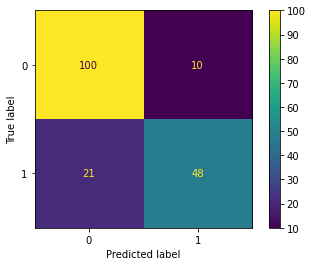

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.69      0.73        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178



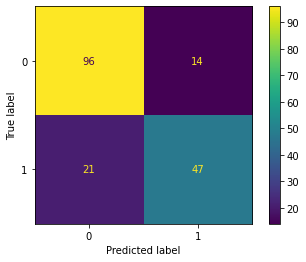

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.74      0.76        68

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.83      0.82       178



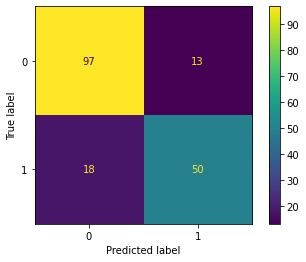

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.78      0.62      0.69        68

    accuracy                           0.79       178
   macro avg       0.78      0.75      0.76       178
weighted avg       0.79      0.79      0.78       178



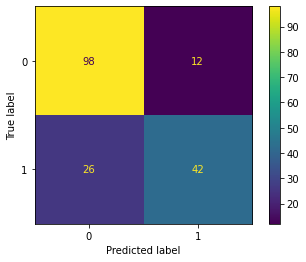

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       109
           1       0.80      0.77      0.79        69

    accuracy                           0.84       178
   macro avg       0.83      0.82      0.83       178
weighted avg       0.84      0.84      0.84       178



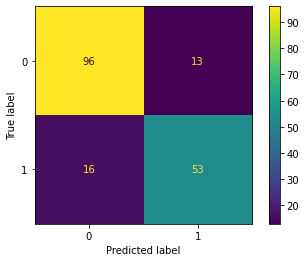

Average Mean: 0.81592 +/- 0.0205
Average Precision: 0.79451 +/- 0.0225
Average Recall: 0.70158 +/- 0.0565
Average F1 Score: 0.74433 +/- 0.0372
Average AUC Score: 0.79432 +/- 0.0271


In [42]:
rfc_accuracies, rfc_precisions, rfc_recalls, rfc_f1_scores, rfc_auc_scores = train("RFC", data.drop('survived', axis=1), data['survived'], config=rfc_config)

## Decision Tree Classifier (DTC) Analysis

In [139]:
wandb.agent(dtc_sweep_id, sweep_dtc, 
            project=PROJECT, entity=ENTITY, 
            count=10)

### [dtc-61a97](https://wandb.ai/nclgbd/Titanic-Classification/sweeps/xha81scg?workspace=user-nclgbd)

<div>
<img src="media/dtc-61a97-best-splitter-low-min-leaves.png" width="600" height="300"/>
</div>

Looking at this graph, 2 things seem immediately clear:
1) Using `splitter='best'` is performing better on average than `splitter='random'`
2) `min_samples_leaf` seems to perform better with values between 1 and 50.

### [dtc-dafa4](https://wandb.ai/nclgbd/Titanic-Classification/sweeps/tesn5duc?workspace=user-nclgbd)

<div>
<img src="media/dafa4-msl-vs-acc.png" width="600" height="300"/>
</div>

From this graph we can see that there is a positive correlation between the `min_samples_leaf`and the average accuracy, it made me wonder if we needed more runs with a higher `min_samples_leaf`.

<div>
<img src="media/dtc-10182-sweep.png" width="600" height="300"/>
</div>

However, changing the search to be [50-100 leaves](https://wandb.ai/nclgbd/Titanic-Classification/sweeps/l9pnjefv?workspace=user-nclgbd), it's was clear that `min_samples_leaf=50` seems to be the sweet spot for this metric. Looking at the criterion, it's also clear that entropy is performing better than gini again, so we'll be using this criterion.


In [111]:
dtc_config = {
    "splitter": "best",
    "min_samples_leaf": 50,
    "criterion": "entropy"
}

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       110
           1       0.75      0.77      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



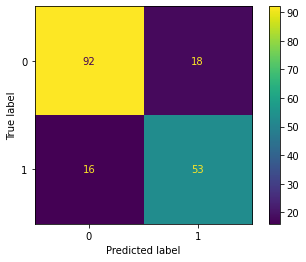

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.69      0.73        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178



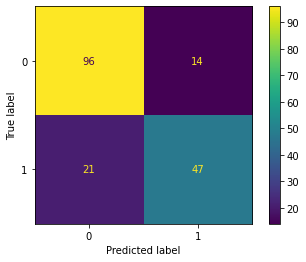

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       110
           1       0.91      0.75      0.82        68

    accuracy                           0.88       178
   macro avg       0.89      0.85      0.86       178
weighted avg       0.88      0.88      0.87       178



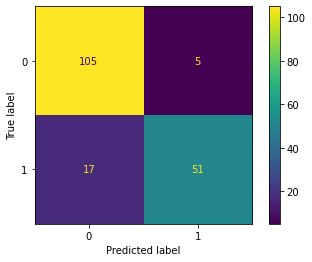

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       110
           1       0.90      0.63      0.74        68

    accuracy                           0.83       178
   macro avg       0.85      0.79      0.81       178
weighted avg       0.84      0.83      0.82       178



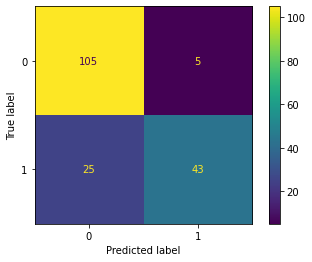

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       109
           1       0.80      0.65      0.72        69

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



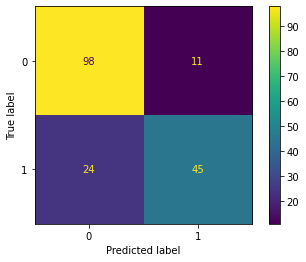

Average Mean: 0.82493 +/- 0.0310
Average Precision: 0.82542 +/- 0.0741
Average Recall: 0.69876 +/- 0.0593
Average F1 Score: 0.75396 +/- 0.0408
Average AUC Score: 0.80111 +/- 0.0304


In [43]:
dtc_accuracies, dtc_precisions, dtc_recalls, dtc_f1_scores, dtc_auc_scores = train("dtc", data.drop('survived', axis=1), data['survived'], config=dtc_config)

# Comparing the models
So lets compare:

**Random Forest Classifier**
```
Average Mean: 0.81592 +/- 0.0205
Average Precision: 0.79451 +/- 0.0225
Average Recall: 0.70158 +/- 0.0565
Average F1 Score: 0.74433 +/- 0.0372
Average AUC Score: 0.79432 +/- 0.0271
```


**Decision Tree Classifier**
```
Average Mean: 0.82493 +/- 0.0310
Average Precision: 0.82542 +/- 0.0741
Average Recall: 0.69876 +/- 0.0593
Average F1 Score: 0.75396 +/- 0.0408
Average AUC Score: 0.80111 +/- 0.0304
```

Comparing these two models, it *seems* like the Random Forest Classifier is better, but is it significantly better? We'll use the `ttest_ind` from `scipy` to see:

In [44]:
from scipy.stats import ttest_ind

t_stat, pval = ttest_ind(rfc_accuracies, dtc_accuracies)
print("t-statistic: ", t_stat)
print("p-value: ", pval)

t-statistic:  -0.5417028925019396
p-value:  0.6027790084799342


So looking at the t-statistic and p-value, the Random Forest Classifier is **not** significantly better than the Decision Tree Classifier

# Submissions
Now that we have our two models trained and hyperparameters tuned, lets submit both and see how they do on the test data. We'll load and transform the test data, and create a function that will properly format the output for submission

In [45]:
rfc = load('models/rfc.joblib') 
dtc = load('models/dtc.joblib') 

In [46]:
test_data['cabin'] = test_data['cabin'].apply(get_first_cabin)
test_data['cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in test_data['cabin']])
test_data["age"] = test_data["age"].replace(np.nan, test_data["age"].median())
test_data['agegroup'] = test_data['age'].apply(create_age_group)
test_data["relatives"] = test_data['sibsp'] + test_data["parch"]
test_data['single'] = test_data["relatives"].apply(create_age_group)
test_data = test_data.drop(["relatives"], axis=1)
test_data['title'] = test_data['name'].apply(get_title)

pid = test_data["passengerid"]
test_data = test_data.drop(labels=['name', 'ticket', "embarked", "passengerid"], axis=1)

In [47]:
data.drop("survived", axis=1)

,pclass,sex,age,sibsp,parch,fare,cabin,agegroup,single,title
0,3,male,22.0,1,0,7.2500,X,1,0,Mr
1,1,female,38.0,1,0,71.2833,C,4,0,Mrs
2,3,female,26.0,0,0,7.9250,X,2,0,Miss
3,1,female,35.0,1,0,53.1000,C,4,0,Mrs
4,3,male,35.0,0,0,8.0500,X,4,0,Mr
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,X,2,0,Other
887,1,female,19.0,0,0,30.0000,B,1,0,Miss
888,3,female,28.0,1,2,23.4500,X,3,0,Miss
889,1,male,26.0,0,0,30.0000,C,2,0,Mr


In [48]:
test_data

,pclass,sex,age,sibsp,parch,fare,cabin,agegroup,single,title
0,3,male,34.5,0,0,7.8292,X,4,0,Mr
1,3,female,47.0,1,0,7.0000,X,5,0,Mrs
2,2,male,62.0,0,0,9.6875,X,5,0,Mr
3,3,male,27.0,0,0,8.6625,X,2,0,Mr
4,3,female,22.0,1,1,12.2875,X,1,0,Mrs
...,...,...,...,...,...,...,...,...,...,...
413,3,male,27.0,0,0,8.0500,X,2,0,Mr
414,1,female,39.0,0,0,108.9000,C,4,0,Other
415,3,male,38.5,0,0,7.2500,X,4,0,Mr
416,3,male,27.0,0,0,8.0500,X,2,0,Mr


In [49]:
rfc_preds = rfc.predict(test_data)
dtc_preds = dtc.predict(test_data)

rfc_sub_dict = list(zip(pid, rfc_preds))
dtc_sub_dict = list(zip(pid, dtc_preds))

In [50]:
with open("data/rfc_submission.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["PassengerId", "Survived"])
    
    for (p, pred) in rfc_sub_dict:
        writer.writerow([p, pred])

![](media\rfc_sub.PNG)

In [51]:
with open("data/dtc_submission.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["PassengerId", "Survived"])
    
    for (p, pred) in dtc_sub_dict:
        writer.writerow([p, pred])

![](media/dtc_sub.PNG)

Well.... they both seem to be getting the same score after some minor tweaking (dropping less relevant features like `passengerid` and `embarked`).

# Conclusion
Placing 4337/14411 I think is a pretty nice achievement, though there's still some more things I could have done to optimize the models. Sklearn's `RandomForestClassifier` and `DecisionTreeClassifier` have many different parameters that can be tuned, so performing more searches on those hyperparameters will like yield better results. Based off the ttest, neither model implementation seems to be significantly better than the other, and this is further seen by getting the same exact score upon submission.

From this project I learned better ways to compare models, and I especially liked using this project to experiment with Weights and Biases, as it made the hyperparameter tuning really easy, and they gave back very nice interactive graphs. I suggest anyone reading this notebook go to the sweep workspaces linked throughout the hyperparameter sweep section, and you can play with the data that's in there. There are other metrics that I used when analyzing the sweeps that I did not go over so much, i.e., correlation between parameters, confusion matrices, metric results from all of the runs, etc. It was nice to have one place to be able to look and recall different runs I did, and I will definitely be using this tool in the future.